<a href="https://colab.research.google.com/github/niplessa/Thesis_Data-mining-study-on-medical-and-sociological-Data-regarding-Covid19/blob/main/Predictions2_Regression_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning and time series predictions


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import numpy as np
import datetime as dt
from datetime import timedelta
 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures
 
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
 
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
!pip install pyramid-arima
from pyramid.arima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [ ]:
path = "https://raw.githubusercontent.com/niplessa/Datasets/main/covid_19_data.csv"
covid  = pd.read_csv(path)

In [ ]:
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
print("Size/Shape of the dataset:\n",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:
 (116805, 8)
Checking for null values:
 SNo                    0
ObservationDate        0
Province/State     35353
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [ ]:
#Dropping column as SNo is of no use, and "Province/State" contains too many missing values
covid.drop(["SNo"],1,inplace=True)
covid.drop(["Province/State"],1,inplace=True)

In [ ]:
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [ ]:
grouped_country=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [ ]:
grouped_country.head(20)

Confirmed  Recovered  Deaths
Country/Region  ObservationDate                              
 Azerbaijan     2020-02-28             1.0        0.0     0.0
('St. Martin',) 2020-03-10             2.0        0.0     0.0
Afghanistan     2020-02-24             1.0        0.0     0.0
                2020-02-25             1.0        0.0     0.0
                2020-02-26             1.0        0.0     0.0
                2020-02-27             1.0        0.0     0.0
                2020-02-28             1.0        0.0     0.0
                2020-02-29             1.0        0.0     0.0
                2020-03-01             1.0        0.0     0.0
                2020-03-02             1.0        0.0     0.0
                2020-03-03             1.0        0.0     0.0
                2020-03-04             1.0        0.0     0.0
                2020-03-05             1.0        0.0     0.0
                2020-03-06             1.0        0.0     0.0
                2020-03-07             1.0        0.0     0.0
                2020-03-08             4.0        0.0     0.0
                2020-03-09             4.0        0.0     0.0
                2020-03-10             5.0        0.0     0.0
                2020-03-11             7.0        0.0     0.0
                2020-03-12             7.0        0.0     0.0

In [ ]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

## Create new dataset -Datewise- cases per date worldwide

In [ ]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})


In [ ]:
#create a new column "Date Since" counting the days after the first date in the dataset
datewise["Days Since"]=datewise.index-datewise.index.min()
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [ ]:
datewise.head()

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-22,555.0,28.0,17.0,0
2020-01-23,653.0,30.0,18.0,1
2020-01-24,941.0,36.0,26.0,2
2020-01-25,1438.0,39.0,42.0,3
2020-01-26,2118.0,52.0,56.0,4


In [ ]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  223
Total number of Confirmed Cases around the World:  31779835.0
Total number of Recovered Cases around the World:  21890442.0
Total number of Deaths Cases around the World:  975104.0
Total number of Active Cases around the World:  8914289.0
Total number of Closed Cases around the World:  22865546.0
Approximate number of Confirmed Cases per Day around the World:  129186.0
Approximate number of Recovered Cases per Day around the World:  88986.0
Approximate number of Death Cases per Day around the World:  3964.0
Approximate number of Confirmed Cases per hour around the World:  5383.0
Approximate number of Recovered Cases per hour around the World:  3708.0
Approximate number of Death Cases per hour around the World:  165.0
Number of Confirmed Cases in last 24 hours:  262748.0
Number of Recovered Cases in last 24 hours:  266008.0
Number of Death Cases in last 24 hours:  5526.0


## Create new dataset countrywise

In [ ]:
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

# Predictions
### Linear Regression for all days in the dataset

In [ ]:
model_scores=[] #list to hold RMSE score for every model

## Linear Regression for the whole dataset

In [ ]:
#split dataset into training and validation sets
train = datewise.iloc[:int(datewise.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = datewise.iloc[int(datewise.shape[0]*0.9):] #validation is the rest 1-X
test = datewise.iloc[:int(datewise.shape[0]*1)] #test dataset

#fit and predict
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1)) #fit datapoints (days/confirmed) into LinReg Model
prediction_valid_linreg = lin_reg.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg))) #append the score to the model score list
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))

#plot
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(test["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=test.index, y=test["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))


#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))


#predicted data
fig.add_trace(go.Scatter(x=test.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Worlwide Confirmed Cases Linear Regression Prediction from day {} to day {} (all days)".format(datewise.index.min(),datewise.index.max()),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()

Root Mean Square Error for Linear Regression:  8400055.472546173


<Figure size 792x432 with 0 Axes>

## - Linear Regression for some days of the dataset (phase 1) - Beginning of the epidemic

In [ ]:
df = pd.DataFrame
df = datewise.loc['2020-3-19':'2020-5-30']
df.drop(["Days Since"],axis=1)
df["Days Since"]=df.index-df.index.min()
df["Days Since"]=df.index-df.index[0]
df["Days Since"]=df["Days Since"].dt.days

train = df.iloc[:int(df.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = df.iloc[int(df.shape[0]*0.9):] #validation is the rest 1-X
test = df

#fit and predict
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1)) #fit datapoints (days/confirmed) into LinReg Model
prediction_valid_linreg = lin_reg.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict
#model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))

#plot
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(test["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=test.index, y=test["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))


#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
#predicted data
fig.add_trace(go.Scatter(x=test.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Worlwide Confirmed Cases Linear Regression Prediction from day {} to day {}".format(df.index.min(),df.index.max()),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))


Root Mean Square Error for Linear Regression:  255517.04358569553


<Figure size 792x432 with 0 Axes>

- By slicing the dataframe from date 19/3 to 24/5 the curve reduces to a straight (linear) line. So even Linear Regression can fit quite well. 
We see that the Means Square error drops dramatically!

In [ ]:
# 22/1/2020 - 30/5/2020
df = pd.DataFrame
df = datewise.loc['2020-1-22':'2020-5-30']
df.drop(["Days Since"],axis=1)
df["Days Since"]=df.index-df.index.min()
df["Days Since"]=df.index-df.index[0]
df["Days Since"]=df["Days Since"].dt.days

train = df.iloc[:int(df.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = df.iloc[int(df.shape[0]*0.9):] #validation is the rest 1-X
test = df

#fit and predict
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1)) #fit datapoints (days/confirmed) into LinReg Model
prediction_valid_linreg = lin_reg.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict
#model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))

#plot
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(test["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))


#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
#predicted data
fig.add_trace(go.Scatter(x=test.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Worlwide Confirmed Cases Linear Regression Prediction from day {} to day {}".format(df.index.min(),df.index.max()),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))


Root Mean Square Error for Linear Regression:  1636830.7593966094


<Figure size 792x432 with 0 Axes>

- If we include days prior to March 15 (the day the curve starts to rise exponentially) we see that the linear model no longer fits the curve.

- So Linear Regression can fit & predict quite accurate only in intervals that the virus' spread is linear. (only short intervals without significant change in the line's inclination)

In [ ]:
#22/6/2020 - 23/9/2020 end of dataset
df = pd.DataFrame
df = datewise.loc['2020-6-22':'2020-9-22']
df.drop(["Days Since"],axis=1)
df["Days Since"]=df.index-df.index.min()
df["Days Since"]=df.index-df.index[0]
df["Days Since"]=df["Days Since"].dt.days

train = df.iloc[:int(df.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = df.iloc[int(df.shape[0]*0.9):] #validation is the rest 1-X
test = df

#fit and predict
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1)) #fit datapoints (days/confirmed) into LinReg Model
prediction_valid_linreg = lin_reg.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict
#model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))

#plot
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(test["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))


#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
#predicted data
fig.add_trace(go.Scatter(x=test.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Worlwide Confirmed Cases Linear Regression Prediction from day {} to day {} (last days)".format(df.index.min(),df.index.max()),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))


Root Mean Square Error for Linear Regression:  583943.6135166935


<Figure size 792x432 with 0 Axes>

# Random Forest Regression

# Polynomial Regression for the whole dataset

- Choose best deegre for polynomial fitting

In [ ]:
train = datewise.iloc[:int(datewise.shape[0]*0.9)]
valid = datewise.iloc[int(datewise.shape[0]*0.9):]
test = datewise

In [ ]:
#try different polynomial degrees from 0 to 9, choose the one with the smallest RMSE error
rmse_poly_min=float('inf')
deegre_best = 0

for i in range(0,10):
  poly = PolynomialFeatures(degree = i)
  train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
  valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
  y=train["Confirmed"]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)
  prediction_poly=linreg.predict(valid_poly)
  rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))

  if (rmse_poly<rmse_poly_min):
    rmse_poly_min = rmse_poly
    deegre_best = i
  print("Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly,i))


print("\nBest Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly_min,deegre_best))


Root Mean Squared Error is: 21688624.5196536 for Polynomial degree : 0 
Root Mean Squared Error is: 8400055.472546183 for Polynomial degree : 1 
Root Mean Squared Error is: 302994.98119402793 for Polynomial degree : 2 
Root Mean Squared Error is: 1305079.1843153494 for Polynomial degree : 3 
Root Mean Squared Error is: 1764112.0858796036 for Polynomial degree : 4 
Root Mean Squared Error is: 729493.156424116 for Polynomial degree : 5 
Root Mean Squared Error is: 3415009.399753284 for Polynomial degree : 6 
Root Mean Squared Error is: 2427213.2089807903 for Polynomial degree : 7 
Root Mean Squared Error is: 1963294.0114732552 for Polynomial degree : 8 
Root Mean Squared Error is: 2352959.3643056955 for Polynomial degree : 9 

Best Root Mean Squared Error is: 302994.98119402793 for Polynomial degree : 2 


In [ ]:
poly = PolynomialFeatures(degree = deegre_best) #choose poly deegre
train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
y=train["Confirmed"]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))
model_scores.append(rmse_poly) #append to model score for Poly Regression
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))

#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))

#predictions
fig.add_trace(go.Scatter(x=test.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction for all dates. Polynomial degree is: {}".format(deegre_best),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()

Root Mean Squared Error for Polynomial Regression:  302994.98119402793


<Figure size 792x432 with 0 Axes>

Training dataset = 0.8 of the original dataset.  
Very good accuracy for fitting and predictions.

### Future Predictions (Poly)

In [ ]:
#new predictions array for PR to be used later
new_prediction_poly=[]

for i in range(0,40):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

## Polynomial Regression for parts of the dataset


- Beginning of data

In [ ]:
df = pd.DataFrame
df = datewise.loc['2020-1-22':'2020-3-15']
df.drop(["Days Since"],axis=1)
df["Days Since"]=df.index-df.index.min()
df["Days Since"]=df.index-df.index[0]
df["Days Since"]=df["Days Since"].dt.days

#try different polynomial degrees from 0 to 9, choose the one with the smallest RMSE error
rmse_poly_min=float('inf')
deegre_best = 0

train = df.iloc[:int(df.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = df.iloc[int(df.shape[0]*0.9):] #validation is the rest 1-X
test = df

for i in range(1,20):
  poly = PolynomialFeatures(degree = i)
  train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
  valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
  y=train["Confirmed"]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)
  prediction_poly=linreg.predict(valid_poly)
  rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))

  if (rmse_poly<rmse_poly_min):
    rmse_poly_min = rmse_poly
    deegre_best = i
  print("Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly,i))


print("\nBest Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly_min,deegre_best))

poly = PolynomialFeatures(degree = deegre_best)
train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
y=train["Confirmed"]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))
#model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))

#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))

#predictions
fig.add_trace(go.Scatter(x=test.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction for dates from {} to {}. Polynomial degree is: {}".format(df.index.min(),df.index.max(),deegre_best),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()


Root Mean Squared Error is: 21872.527673883513 for Polynomial degree : 1 
Root Mean Squared Error is: 29630.8909285591 for Polynomial degree : 2 
Root Mean Squared Error is: 40463.15005145695 for Polynomial degree : 3 
Root Mean Squared Error is: 3070.1112017475666 for Polynomial degree : 4 
Root Mean Squared Error is: 19066.54947259085 for Polynomial degree : 5 
Root Mean Squared Error is: 16288.98716303322 for Polynomial degree : 6 
Root Mean Squared Error is: 64567.27358229219 for Polynomial degree : 7 
Root Mean Squared Error is: 26210.996850481675 for Polynomial degree : 8 
Root Mean Squared Error is: 141974.18646673884 for Polynomial degree : 9 
Root Mean Squared Error is: 8471.51909650057 for Polynomial degree : 10 
Root Mean Squared Error is: 657743.4767802734 for Polynomial degree : 11 
Root Mean Squared Error is: 92925.38004621762 for Polynomial degree : 12 
Root Mean Squared Error is: 1747426.0512847442 for Polynomial degree : 13 
Root Mean Squared Error is: 1996124.44510944

<Figure size 792x432 with 0 Axes>

In [ ]:
df = pd.DataFrame
df = datewise.loc['2020-3-15':'2020-5-30']
df.drop(["Days Since"],axis=1)
df["Days Since"]=df.index-df.index.min()
df["Days Since"]=df.index-df.index[0]
df["Days Since"]=df["Days Since"].dt.days
#try different polynomial degrees from 0 to 9, choose the one with the smallest RMSE error
rmse_poly_min=float('inf')
deegre_best = 0

train = df.iloc[:int(df.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = df.iloc[int(df.shape[0]*0.9):] #validation is the rest 1-X
test = df

for i in range(0,10):
  poly = PolynomialFeatures(degree = i)
  train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
  valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
  y=train["Confirmed"]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)
  prediction_poly=linreg.predict(valid_poly)
  rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))

  if (rmse_poly<rmse_poly_min):
    rmse_poly_min = rmse_poly
    deegre_best = i
  print("Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly,i))


print("\nBest Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly_min,deegre_best))

poly = PolynomialFeatures(degree = deegre_best)
train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
y=train["Confirmed"]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))
#model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))

#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))

#predictions
fig.add_trace(go.Scatter(x=test.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction for dates from {} to {}. Polynomial degree is: {}".format(df.index.min(),df.index.max(),deegre_best),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()


Root Mean Squared Error is: 3292332.1768399132 for Polynomial degree : 0 
Root Mean Squared Error is: 308057.3937582522 for Polynomial degree : 1 
Root Mean Squared Error is: 23570.842288987384 for Polynomial degree : 2 
Root Mean Squared Error is: 226382.58298242325 for Polynomial degree : 3 
Root Mean Squared Error is: 146742.0185668547 for Polynomial degree : 4 
Root Mean Squared Error is: 15588.21072966065 for Polynomial degree : 5 
Root Mean Squared Error is: 60286.442250200824 for Polynomial degree : 6 
Root Mean Squared Error is: 214629.52922093828 for Polynomial degree : 7 
Root Mean Squared Error is: 35733.805293367994 for Polynomial degree : 8 
Root Mean Squared Error is: 299711.4158803106 for Polynomial degree : 9 

Best Root Mean Squared Error is: 15588.21072966065 for Polynomial degree : 5 
Root Mean Squared Error for Polynomial Regression:  15588.21072966065


<Figure size 792x432 with 0 Axes>

## End of data (Polynomial Regression)

In [ ]:
df = pd.DataFrame
df = datewise.loc['2020-7-15':'2020-9-23']
df.drop(["Days Since"],axis=1)
df["Days Since"]=df.index-df.index.min()
df["Days Since"]=df.index-df.index[0]
df["Days Since"]=df["Days Since"].dt.days
#try different polynomial degrees from 0 to 9, choose the one with the smallest RMSE error
rmse_poly_min=float('inf')
deegre_best = 0

train = df.iloc[:int(df.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = df.iloc[int(df.shape[0]*0.9):] #validation is the rest 1-X
test = df

for i in range(0,10):
  poly = PolynomialFeatures(degree = i)
  train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
  valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
  y=train["Confirmed"]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)
  prediction_poly=linreg.predict(valid_poly)
  rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))

  if (rmse_poly<rmse_poly_min):
    rmse_poly_min = rmse_poly
    deegre_best = i
  print("Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly,i))


print("\nBest Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly_min,deegre_best))

poly = PolynomialFeatures(degree = deegre_best)
train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
y=train["Confirmed"]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))
#model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))

#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))

#predictions
fig.add_trace(go.Scatter(x=test.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction for dates from {} to {}. Polynomial degree is: {}".format(df.index.min(),df.index.max(),deegre_best),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()


Root Mean Squared Error is: 9404970.347218094 for Polynomial degree : 0 
Root Mean Squared Error is: 256119.48972625288 for Polynomial degree : 1 
Root Mean Squared Error is: 140631.56314598848 for Polynomial degree : 2 
Root Mean Squared Error is: 97560.16774452874 for Polynomial degree : 3 
Root Mean Squared Error is: 74340.78871708052 for Polynomial degree : 4 
Root Mean Squared Error is: 135014.19232919635 for Polynomial degree : 5 
Root Mean Squared Error is: 178352.88710313794 for Polynomial degree : 6 
Root Mean Squared Error is: 40724.772577037336 for Polynomial degree : 7 
Root Mean Squared Error is: 650601.2624056278 for Polynomial degree : 8 
Root Mean Squared Error is: 1645920.614555875 for Polynomial degree : 9 

Best Root Mean Squared Error is: 40724.772577037336 for Polynomial degree : 7 
Root Mean Squared Error for Polynomial Regression:  40724.772577037336


<Figure size 792x432 with 0 Axes>

#SVM Regressor (Support Vector Machines)


In [ ]:
train=datewise.iloc[:int(datewise.shape[0]*0.9)]
valid=datewise.iloc[int(datewise.shape[0]*0.9):]
test = datewise

#Intializing SVR Model
svm=SVR(C=1,degree=8,kernel='poly',epsilon=0.01)

#Fitting model on the training data
svm.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1))

prediction_valid_svm=svm.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict

model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_svm)))

plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))

#training
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
#prediction
fig.add_trace(go.Scatter(x=test.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Confirmed Cases Support Vector Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()

Root Mean Square Error for Support Vectore Machine:  30215665.61425219


<Figure size 792x432 with 0 Axes>

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

train=datewise.iloc[:int(datewise.shape[0]*0.9)]
valid=datewise.iloc[int(datewise.shape[0]*0.9):]
test = datewise

#Intializing SVR Model
logreg = LogisticRegression(random_state=0)

#Fitting model on the training data
logreg.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1))

prediction_valid_logreg=logreg.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict

#model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_logreg)))
print("Root Mean Square Error for Logistic Regression: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_logreg)))

plt.figure(figsize=(11,6))
prediction_logreg=logreg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))

#training
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
#prediction
fig.add_trace(go.Scatter(x=test.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Confirmed Cases Logistic Regresiion Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()

Root Mean Square Error for Logistic Regression:  4217662.493696355


<Figure size 792x432 with 0 Axes>

# Predict for the future (outside the dataset)

In [ ]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]

for i in range(1,40): #choose how many days forward
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression","Polynomial Regression","SVM"])
model_predictions.head(5)


,Dates,Linear Regression,Polynomial Regression,SVM
0,2020-09-24,68437195.939759,31674293.371618,83549747.930509
1,2020-09-25,68681845.381722,31978128.236158,86211441.624214
2,2020-09-26,68926494.823685,32283408.390003,88949646.455313
3,2020-09-27,69171144.265648,32590133.833152,91766239.881386
4,2020-09-28,69415793.707611,32898304.565605,94663137.595557


In [ ]:
#plot future predictions for the 3 models
plt.figure(figsize=(11,6))
fig=go.Figure()

#Lin Regression
fig.add_trace(go.Scatter(x=model_predictions["Dates"], y=model_predictions["Linear Regression"],
                    mode='lines+markers',name="Linear Regression Prediction"))

#Polynomial Regression
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Polynomial Regression"],
                    mode='lines+markers',name="Polynonmial Regression Prediction"))
#SVM Regressor
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["SVM"],
                    mode='lines+markers',name="SVM Regressor Prediction"))

fig.update_layout(title="Predictions until 01/11 from the 3 models",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()

<Figure size 792x432 with 0 Axes>

- SVM and LinReg predictions are out of place.

- Polynomial Regression though gives for **October 31 43.8 million cases**. **Worldometer for the same date declares 46 mil cases**. Quite good accuracy for a month after!

### Model accuracy scores

In [ ]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","RMSE"]).sort_values(["RMSE"])
model_summary


,Model Name,RMSE
1,Polynomial Regression,302994.981194
0,Linear Regression,8400055.472546
2,Support Vector Machine Regressor,30215665.614252


- Of course Polynomial Regression has the smaller RMS error from the 3 models.



---

#Time series predictions (forecasts)

###Holt's Linear Model

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.9)]
valid=datewise.iloc[int(datewise.shape[0]*0.9):]
y_pred=valid.copy()

holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)  

y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

fig=go.Figure()
#training data
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))

#validation
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))

#predictions
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Root Mean Square Error Holt's Linear Model:  59841.86879366861


In [ ]:
#predictions for holt's model
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,40):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression,Polynomial Regression,SVM,Holt's Linear Model
0,2020-09-24,68437195.939759,31674293.371618,83549747.930509,31939062.013039
1,2020-09-25,68681845.381722,31978128.236158,86211441.624214,32206852.794506
2,2020-09-26,68926494.823685,32283408.390003,88949646.455313,32474643.575973
3,2020-09-27,69171144.265648,32590133.833152,91766239.881386,32742434.357440
4,2020-09-28,69415793.707611,32898304.565605,94663137.595557,33010225.138906


###Holt's Winter Model for Daily Time Series

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=14,trend='add', seasonal='mul').fit()

y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Root Mean Square Error for Holt's Winter Model:  121656.62220388037


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
holt_winter_new_prediction=[]
for i in range(1,40):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression,Polynomial Regression,SVM,Holt's Linear Model,Holt's Winter Model Prediction
0,2020-09-24,68437195.939759,31674293.371618,83549747.930509,31939062.013039,31902422.036485
1,2020-09-25,68681845.381722,31978128.236158,86211441.624214,32206852.794506,32216310.816524
2,2020-09-26,68926494.823685,32283408.390003,88949646.455313,32474643.575973,32497522.776590
3,2020-09-27,69171144.265648,32590133.833152,91766239.881386,32742434.357440,32723879.802983
4,2020-09-28,69415793.707611,32898304.565605,94663137.595557,33010225.138906,32977149.059209


###AR model

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
model_ar= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed"])

prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))

fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Fit ARIMA: order=(0, 2, 0); AIC=5238.720, BIC=5245.605, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=5226.956, BIC=5237.284, Fit time=0.021 seconds
Fit ARIMA: order=(2, 2, 0); AIC=5227.940, BIC=5241.709, Fit time=0.024 seconds
Fit ARIMA: order=(3, 2, 0); AIC=5189.281, BIC=5206.493, Fit time=0.124 seconds
Fit ARIMA: order=(4, 2, 0); AIC=5144.201, BIC=5164.856, Fit time=0.127 seconds
Total fit time: 0.305 seconds
Root Mean Square Error for AR Model:  37040.640953734335


In [ ]:
AR_model_new_prediction=[]
for i in range(1,40):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,Dates,Linear Regression,Polynomial Regression,SVM,Holt's Linear Model,Holt's Winter Model Prediction,AR Model Prediction
0,2020-09-24,68437195.939759,31674293.371618,83549747.930509,31939062.013039,31902422.036485,32076857.213284
1,2020-09-25,68681845.381722,31978128.236158,86211441.624214,32206852.794506,32216310.816524,32362700.174347
2,2020-09-26,68926494.823685,32283408.390003,88949646.455313,32474643.575973,32497522.776590,32648202.101267
3,2020-09-27,69171144.265648,32590133.833152,91766239.881386,32742434.357440,32723879.802983,32937157.868152
4,2020-09-28,69415793.707611,32898304.565605,94663137.595557,33010225.138906,32977149.059209,33230717.108223


### Facebook Prophet Time Series Predictor

- check documentations:  
https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
###Facebook Prophet time series model
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,) #init prophet model

#prophet accept as input only 2 variables? ds = date , y = value to fit/predict
#we create a new dataframe for prophet with ds -> datewise.Dates , y=datewise.Confirmed
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_c=prophet_c.make_future_dataframe(periods=30) #make dataframe with extra days| periods = extra dates after the last day on the set 
forecast_confirmed=forecast_c.copy()

confirmed_forecast=prophet_c.predict(forecast_c) #predict
print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])
#yhat -> prediction value (lower/upper are the bounds for this value, the range)

            ds            yhat      yhat_lower      yhat_upper
0   2020-01-22   -14614.727595   -81997.234826    59722.229841
1   2020-01-23    -7889.259050   -81295.841042    61944.746981
2   2020-01-24     9725.063933   -60127.946632    81374.799962
3   2020-01-25    14274.749753   -61069.787080    87192.407205
4   2020-01-26     2110.033153   -68769.064241    71096.806614
..         ...             ...             ...             ...
271 2020-10-19 38412490.457714 37531977.738414 39172766.827088
272 2020-10-20 38673816.313094 37751700.396583 39471578.954402
273 2020-10-21 38942819.859600 37947491.345896 39798949.511419
274 2020-10-22 39208723.558232 38155640.841950 40094542.177405
275 2020-10-23 39485516.111302 38390823.354691 40429760.396561

[276 rows x 4 columns]


In [ ]:
#compute RMSE for Prophet Model
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],\
                                               confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],\
                                                                               confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  37359.72047579066


Figure(720x432)


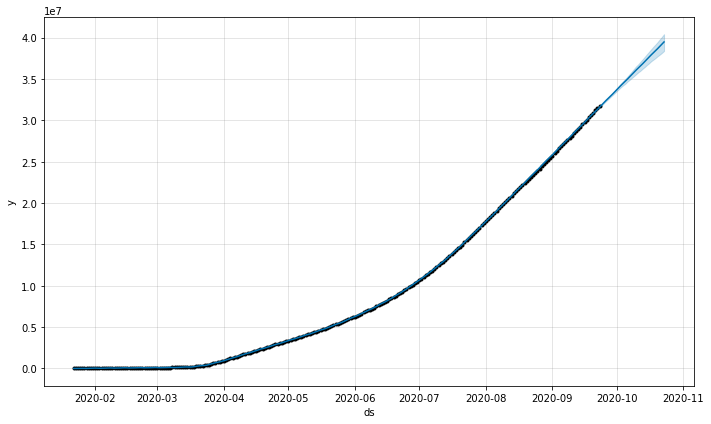

In [ ]:
print(prophet_c.plot(confirmed_forecast))

Figure(648x432)


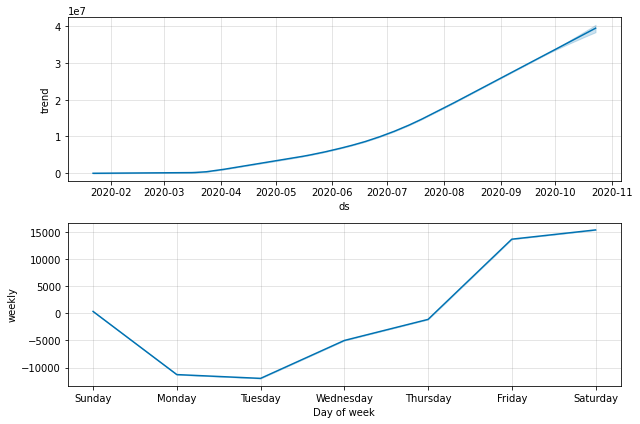

In [ ]:
print(prophet_c.plot_components(confirmed_forecast))

### Root Squared Mean Error for all models

In [ ]:
model_names=["Linear Regression","Polynomial Regression","SVM Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model","Fb's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"])#.sort_values(["Root Mean Squared Error"])
model_summary


,Model Name,Root Mean Squared Error
0,Linear Regression,8400055.472546
1,Polynomial Regression,302994.981194
2,SVM Regressor,30215665.614252
3,Holt's Linear,59841.868794
4,Holt's Winter Model,121656.622204
5,Auto Regressive Model,37040.640954
6,Fb's Prophet Model,37359.720476


In [ ]:
#sort by RMSE
pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])


,Model Name,Root Mean Squared Error
5,Auto Regressive Model,37040.640954
6,Fb's Prophet Model,37359.720476
3,Holt's Linear,59841.868794
4,Holt's Winter Model,121656.622204
1,Polynomial Regression,302994.981194
0,Linear Regression,8400055.472546
2,SVM Regressor,30215665.614252


- AR model has the least Error. Time Series model fit better...

###Plot for all models

In [ ]:
#prophet predictions outside of dataset
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(39))
model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(39))
model_predictions.head()

,Dates,Linear Regression,Polynomial Regression,SVM,Holt's Linear Model,Holt's Winter Model Prediction,AR Model Prediction,Prophet's Prediction,Prophet's Upper Bound
0,2020-09-24,68437195.939759,31674293.371618,83549747.930509,31939062.013039,31902422.036485,32076857.213284,29503014.143019,29575330.900006
1,2020-09-25,68681845.381722,31978128.236158,86211441.624214,32206852.794506,32216310.816524,32362700.174347,29772017.689525,29846893.759339
2,2020-09-26,68926494.823685,32283408.390003,88949646.455313,32474643.575973,32497522.776590,32648202.101267,30037921.388157,30108174.877395
3,2020-09-27,69171144.265648,32590133.833152,91766239.881386,32742434.357440,32723879.802983,32937157.868152,30314713.941227,30387087.225588
4,2020-09-28,69415793.707611,32898304.565605,94663137.595557,33010225.138906,32977149.059209,33230717.108223,30578441.857135,30651444.296146


In [ ]:
#plot future predictions for all the models
plt.figure(figsize=(11,6))
fig=go.Figure()



#Holts Linear Model
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Holt's Linear Model"],
                    mode='lines+markers',name="Holt's Linear Model Prediction"))

#Holts Winter Model
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Holt's Winter Model Prediction"],
                    mode='lines+markers',name="Holt's Winter Model Prediction"))

#AR
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["AR Model Prediction"],
                    mode='lines+markers',name="AR Model Prediction"))


#Prophet
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Prophet's Prediction"],
                    mode='lines+markers',name="Fb Prophet Model Prediction"))



fig.update_layout(title="Predictions until 01/11 from all the models",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

- On November 1 the actual cases are 46,441,113 (Worldometer).  

**Polynomial Regression still predicts closer to the actual values despite time series models fitting better**


# Predictions in **country** level

In [ ]:
#country = input() #ask the user for country
country = "Russia"
df_country = covid[covid['Country/Region']==country].reset_index(drop=True) #create new df for this specific country
country_datewise = df_country.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

#add "Days Since column"
country_datewise["Days Since"]=country_datewise.index-datewise.index.min()
country_datewise["Days Since"]=country_datewise.index-country_datewise.index[0]
country_datewise["Days Since"]=country_datewise["Days Since"].dt.days

In [ ]:
country_datewise.head()

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-31,2.000000,0.000000,0.000000,0
2020-02-01,2.000000,0.000000,0.000000,1
2020-02-02,2.000000,0.000000,0.000000,2
2020-02-03,2.000000,0.000000,0.000000,3
2020-02-04,2.000000,0.000000,0.000000,4


#All models prediction

In [ ]:
model_scores_country = []

In [ ]:
#split dataset into training and validation sets
train = country_datewise.iloc[:int(datewise.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = country_datewise.iloc[int(datewise.shape[0]*0.9):] #validation is the rest 1-X
test = country_datewise.iloc[:int(datewise.shape[0]*1)] #test dataset

In [ ]:
#ALL MODELS PREDICTION

# Lin Reg
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1)) #fit datapoints (days/confirmed) into LinReg Model
prediction_valid_linreg = lin_reg.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict
model_scores_country.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg))) #append the score to the model score list
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))

#plot
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(test["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])


#Poly Reg

#try different polynomial degrees from 0 to 9, choose the one with the smallest RMSE error
rmse_poly_min=float('inf')
deegre_best = 0
for i in range(0,10):
  poly = PolynomialFeatures(degree = i)
  train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
  valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
  y=train["Confirmed"]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)
  prediction_poly=linreg.predict(valid_poly)
  rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))

  if (rmse_poly<rmse_poly_min):
    rmse_poly_min = rmse_poly
    deegre_best = i
  print("Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly,i))


print("\nBest Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly_min,deegre_best))

poly = PolynomialFeatures(degree = deegre_best) #choose poly deegre
train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
y=train["Confirmed"]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

#SVM
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

#Fitting model on the training data
svm.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1))

prediction_valid_svm=svm.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict

print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_svm)))

plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))

fig=go.Figure()


#validation data
fig.add_trace(go.Scatter(x=test.index, y=test["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))


#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
#poly
fig.add_trace(go.Scatter(x=test.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='green', dash='dot')))

fig.add_trace(go.Scatter(x=test.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='magenta', dash='dot')))

#lin
fig.add_trace(go.Scatter(x=test.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="{}'s Confirmed Cases Predictions (all days)".format(country),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()

Root Mean Square Error for Linear Regression:  30264.149142560327
Root Mean Squared Error is: 692513.6226591503 for Polynomial degree : 0 
Root Mean Squared Error is: 30264.149142560425 for Polynomial degree : 1 
Root Mean Squared Error is: 166444.38675667817 for Polynomial degree : 2 
Root Mean Squared Error is: 68233.71917989332 for Polynomial degree : 3 
Root Mean Squared Error is: 122199.61020383115 for Polynomial degree : 4 
Root Mean Squared Error is: 81097.26693958793 for Polynomial degree : 5 
Root Mean Squared Error is: 52761.51819958772 for Polynomial degree : 6 
Root Mean Squared Error is: 141206.27891819 for Polynomial degree : 7 
Root Mean Squared Error is: 8023.397962639571 for Polynomial degree : 8 
Root Mean Squared Error is: 184721.7603263847 for Polynomial degree : 9 

Best Root Mean Squared Error is: 8023.397962639571 for Polynomial degree : 8 
Root Mean Squared Error for Polynomial Regression:  8023.397962639571
Root Mean Square Error for Support Vectore Machine:  9

<Figure size 792x432 with 0 Axes>

<Figure size 792x432 with 0 Axes>

<Figure size 792x432 with 0 Axes>

## Polynomial Regression

In [ ]:
#try different polynomial degrees from 0 to 9, choose the one with the smallest RMSE error
rmse_poly_min=float('inf')
deegre_best = 0

for i in range(0,10):
  poly = PolynomialFeatures(degree = i)
  train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
  valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
  y=train["Confirmed"]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)
  prediction_poly=linreg.predict(valid_poly)
  rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))

  if (rmse_poly<rmse_poly_min):
    rmse_poly_min = rmse_poly
    deegre_best = i
  print("Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly,i))


print("\nBest Root Mean Squared Error is: {} for Polynomial degree : {} ".format(rmse_poly_min,deegre_best))

poly = PolynomialFeatures(degree = deegre_best) #choose poly deegre
train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
y=train["Confirmed"]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)

rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))
model_scores_country.append(rmse_poly) #append to model score for Poly Regression
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))

#training data
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))

#predictions
fig.add_trace(go.Scatter(x=test.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction for {}. Polynomial degree is: {}".format(country,deegre_best),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=15))
fig.show()

Root Mean Squared Error is: 692513.6226591503 for Polynomial degree : 0 
Root Mean Squared Error is: 30264.149142560425 for Polynomial degree : 1 
Root Mean Squared Error is: 166444.38675667817 for Polynomial degree : 2 
Root Mean Squared Error is: 68233.71917989332 for Polynomial degree : 3 
Root Mean Squared Error is: 122199.61020383115 for Polynomial degree : 4 
Root Mean Squared Error is: 81097.26693958793 for Polynomial degree : 5 
Root Mean Squared Error is: 52761.51819958772 for Polynomial degree : 6 
Root Mean Squared Error is: 141206.27891819 for Polynomial degree : 7 
Root Mean Squared Error is: 8023.397962639571 for Polynomial degree : 8 
Root Mean Squared Error is: 184721.7603263847 for Polynomial degree : 9 

Best Root Mean Squared Error is: 8023.397962639571 for Polynomial degree : 8 
Root Mean Squared Error for Polynomial Regression:  8023.397962639571


<Figure size 792x432 with 0 Axes>

In [ ]:
#new predictions array for PR to be used later
new_prediction_poly=[]

for i in range(0,40):
    new_date_poly=poly.fit_transform(np.array(country_datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

## SVM Regressor

In [ ]:
#split dataset into training and validation sets
train = country_datewise.iloc[:int(datewise.shape[0]*0.9)] #training dataset is the X of the whole dataset
valid = country_datewise.iloc[int(datewise.shape[0]*0.9):] #validation is the rest 1-X
test = country_datewise #test dataset


#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

#Fitting model on the training data
svm.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1))

prediction_valid_svm=svm.predict(np.array(valid["Days Since"]).reshape(-1,1)) #predict

model_scores_country.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_svm)))

plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()

#validation data
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",
                    line=dict(color='cyan', dash='dot')))

#training
fig.add_trace(go.Scatter(x=train.index, y=train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
#prediction
fig.add_trace(go.Scatter(x=test.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))

fig.update_layout(title="Confirmed Cases Support Vector Machine Regressor Prediction for {}".format(country),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Root Mean Square Error for Support Vectore Machine:  906703.6323388417


<Figure size 792x432 with 0 Axes>

## New Predictions

In [ ]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]

for i in range(1,40): #choose how many days forward
    new_date.append(country_datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(country_datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(country_datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression","Polynomial Regression","SVM"])
model_predictions.head(5)


,Dates,Linear Regression,Polynomial Regression,SVM
0,2020-09-24,1090786.002702,1138335.423588,2399673.072270
1,2020-09-25,1096370.553904,1150102.523410,2458520.467632
2,2020-09-26,1101955.105106,1162828.613245,2518617.224897
3,2020-09-27,1107539.656309,1176606.334894,2579984.474267
4,2020-09-28,1113124.207511,1191534.668970,2642643.612845


In [ ]:
#plot future predictions for the 3 models
plt.figure(figsize=(11,6))
fig=go.Figure()

#Lin Regression
fig.add_trace(go.Scatter(x=model_predictions["Dates"], y=model_predictions["Linear Regression"],
                    mode='lines+markers',name="Linear Regression Prediction"))

#Polynomial Regression
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Polynomial Regression"],
                    mode='lines+markers',name="Polynonmial Regression Prediction"))
#SVM Regressor
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["SVM"],
                    mode='lines+markers',name="SVM Regressor Prediction"))

fig.update_layout(title="Predictions until 1/11 from the 3 models. Country: {}".format(country),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

## Model RMSE scores

In [ ]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor"]
model_summary=pd.DataFrame(zip(model_names,model_scores_country),columns=["Model Name","RMSE"]).sort_values(["RMSE"])
model_summary


,Model Name,RMSE
1,Polynomial Regression,8023.397963
0,Linear Regression,30264.149143
2,Support Vector Machine Regressor,906703.632339


# Time Series Forecasts for specific countries

## Holt's Lin Model


In [ ]:
model_train=country_datewise.iloc[:int(country_datewise.shape[0]*0.95)]
valid=country_datewise.iloc[int(country_datewise.shape[0]*0.95):]
y_pred=valid.copy()

holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)  

y_pred["Holt"]=holt.forecast(len(valid))
model_scores_country.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

fig=go.Figure()
#training data
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))

#validation
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))

#predictions
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction. Country: {}".format(country),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Root Mean Square Error Holt's Linear Model:  3348.7242003417327


In [ ]:
#predictions for holt's model
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,40):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression,Polynomial Regression,SVM,Holt's Linear Model
0,2020-09-24,1090786.002702,1138335.423588,2399673.072270,1116027.751423
1,2020-09-25,1096370.553904,1150102.523410,2458520.467632,1121259.969076
2,2020-09-26,1101955.105106,1162828.613245,2518617.224897,1126492.186729
3,2020-09-27,1107539.656309,1176606.334894,2579984.474267,1131724.404382
4,2020-09-28,1113124.207511,1191534.668970,2642643.612845,1136956.622035


## Holt's Winter Model

In [ ]:
es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=14,trend='add', seasonal='mul').fit()

y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores_country.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction. Country: {}".format(country),
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Root Mean Square Error for Holt's Winter Model:  1880.1652985457333


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
holt_winter_new_prediction=[]
for i in range(1,40):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression,Polynomial Regression,SVM,Holt's Linear Model,Holt's Winter Model Prediction
0,2020-09-24,1090786.002702,1138335.423588,2399673.072270,1116027.751423,1118663.369906
1,2020-09-25,1096370.553904,1150102.523410,2458520.467632,1121259.969076,1124079.767281
2,2020-09-26,1101955.105106,1162828.613245,2518617.224897,1126492.186729,1129496.164656
3,2020-09-27,1107539.656309,1176606.334894,2579984.474267,1131724.404382,1134912.562030
4,2020-09-28,1113124.207511,1191534.668970,2642643.612845,1136956.622035,1140328.959405


## AR Model

In [ ]:
model_ar= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed"])

prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

model_scores_country.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))

fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction. Country: {}".format(country),
                 xaxis_title="Date",yaxis_title="Confirmed Cases ",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Fit ARIMA: order=(0, 2, 0); AIC=3259.609, BIC=3266.424, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3256.503, BIC=3266.725, Fit time=0.043 seconds
Fit ARIMA: order=(2, 2, 0); AIC=3252.379, BIC=3266.008, Fit time=0.096 seconds
Fit ARIMA: order=(3, 2, 0); AIC=3252.850, BIC=3269.886, Fit time=0.083 seconds
Fit ARIMA: order=(4, 2, 0); AIC=3251.855, BIC=3272.298, Fit time=0.151 seconds
Total fit time: 0.384 seconds
Root Mean Square Error for AR Model:  570.9344849978829


In [ ]:
#new predictions outside the dataset
AR_model_new_prediction=[]
for i in range(1,40):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,Dates,Linear Regression,Polynomial Regression,SVM,Holt's Linear Model,Holt's Winter Model Prediction,AR Model Prediction
0,2020-09-24,1090786.002702,1138335.423588,2399673.072270,1116027.751423,1118663.369906,1121961.612876
1,2020-09-25,1096370.553904,1150102.523410,2458520.467632,1121259.969076,1124079.767281,1127822.471525
2,2020-09-26,1101955.105106,1162828.613245,2518617.224897,1126492.186729,1129496.164656,1133708.065288
3,2020-09-27,1107539.656309,1176606.334894,2579984.474267,1131724.404382,1134912.562030,1139618.377398
4,2020-09-28,1113124.207511,1191534.668970,2642643.612845,1136956.622035,1140328.959405,1145553.355798


## Prophet Model

In [ ]:
###Facebook Prophet time series model
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,) #init prophet model

#prophet accept as input only 2 variables? ds = date , y = value to fit/predict
#we create a new dataframe for prophet with ds -> datewise.Dates , y=datewise.Confirmed
prophet_confirmed=pd.DataFrame(zip(list(country_datewise.index),list(country_datewise["Confirmed"])),columns=['ds','y'])
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_c=prophet_c.make_future_dataframe(periods=30) #make dataframe with extra days| periods = extra dates after the last day on the set 
forecast_confirmed=forecast_c.copy()

confirmed_forecast=prophet_c.predict(forecast_c) #predict
print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])
#yhat -> prediction value (lower/upper are the bounds for this value, the range)

            ds           yhat     yhat_lower     yhat_upper
0   2020-01-31    -144.552961   -2436.860343    1983.850089
1   2020-02-01    -119.713341   -2275.620493    2082.767767
2   2020-02-02       7.556160   -2233.221074    2154.518447
3   2020-02-03      58.958725   -2052.411900    2331.590583
4   2020-02-04     132.001877   -2043.383761    2293.326068
..         ...            ...            ...            ...
262 2020-10-19 1241103.546508 1194750.629136 1292658.288277
263 2020-10-20 1246201.557547 1198529.004338 1300999.658897
264 2020-10-21 1251247.385379 1200600.470793 1309664.455452
265 2020-10-22 1256044.825088 1203366.818570 1318494.730752
266 2020-10-23 1261001.507355 1204514.904374 1327336.508105

[267 rows x 4 columns]


In [ ]:
#compute RMSE for Prophet Model
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],\
                                               confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],\
                                                                               confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  12596375.788170438


Figure(720x432)


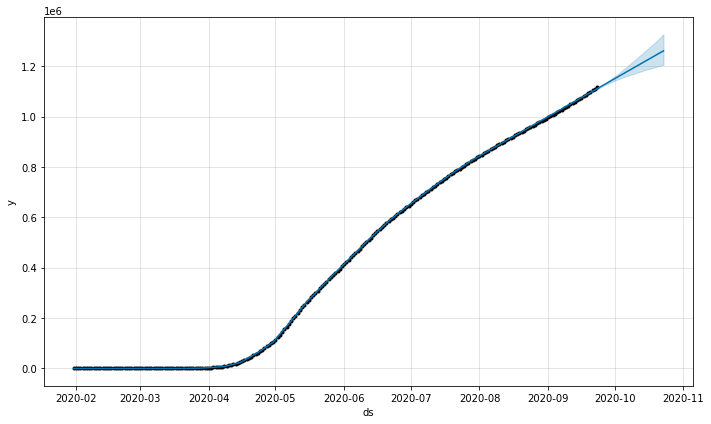

In [ ]:
print(prophet_c.plot(confirmed_forecast))

In [ ]:
#prophet predictions outside of dataset
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(39))
model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(39))
model_predictions.head()

,Dates,Linear Regression,Polynomial Regression,SVM,Holt's Linear Model,Holt's Winter Model Prediction,AR Model Prediction,Prophet's Prediction,Prophet's Upper Bound
0,2020-09-24,1090786.002702,1138335.423588,2399673.072270,1116027.751423,1118663.369906,1121961.612876,1070319.676588,1072494.290587
1,2020-09-25,1096370.553904,1150102.523410,2458520.467632,1121259.969076,1124079.767281,1127822.471525,1075365.504420,1077639.577290
2,2020-09-26,1101955.105106,1162828.613245,2518617.224897,1126492.186729,1129496.164656,1133708.065288,1080162.944129,1082234.212078
3,2020-09-27,1107539.656309,1176606.334894,2579984.474267,1131724.404382,1134912.562030,1139618.377398,1085119.626396,1087296.715414
4,2020-09-28,1113124.207511,1191534.668970,2642643.612845,1136956.622035,1140328.959405,1145553.355798,1090169.433902,1092541.874448


## RMSE error for all models

In [ ]:
model_names=["Linear Regression","Polynomial Regression","SVM Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model","Fb's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores_country),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary


,Model Name,Root Mean Squared Error
5,Auto Regressive Model,570.934485
4,Holt's Winter Model,1880.165299
3,Holt's Linear,3348.724200
1,Polynomial Regression,8023.397963
0,Linear Regression,30264.149143
2,SVM Regressor,906703.632339


#Plot for all models

In [ ]:
#plot future predictions for all the models
plt.figure(figsize=(11,6))
fig=go.Figure()

#Lin Regression
fig.add_trace(go.Scatter(x=model_predictions["Dates"], y=model_predictions["Linear Regression"],
                    mode='lines+markers',name="Linear Regression Prediction"))

#Polynomial Regression
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Polynomial Regression"],
                    mode='lines+markers',name="Polynonmial Regression Prediction"))
#SVM Regressor
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["SVM"],
                    mode='lines+markers',name="SVM Regressor Prediction"))

#Holts Linear Model
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Holt's Linear Model"],
                    mode='lines+markers',name="Holt's Linear Model Prediction"))

#Holts Winter Model
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Holt's Winter Model Prediction"],
                     mode='lines+markers',name="Holt's Winter Model Prediction"))

#Holts Winter Model
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions["Prophet's Prediction"],
                    mode='lines+markers',name="Fb Prophet Model Prediction"))



fig.update_layout(title="Predictions until 1/11 from all the models",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>